In [2]:
# dependencies for file reading
import json
import sys
import itertools
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import soundfile as sf
import importlib
import math
import librosa # conda install -c conda-forge librosa
import seaborn as sns

#Synth Interface (SI)
from utils import sine, triangle, sawtooth
from genericsynth import synthInterface as SI # the base model for all synths, also some utilities 

### Demo of DSSynth interface for creating and exploring Textures
An interactive visualizer is to explore sound models and create textures. It is mostly for understanding the synthesizer, and exploring parameters that you might help you decide how you want to specify them in your config file.

## 1. Load soundModels

In [3]:
soundModels = {}
def loadSoundModels():
    dirpath = "soundModels/"
    modules = [f for f in os.listdir(os.path.dirname(dirpath)) if f[0] != "." and f[0] != "_"]
    for module in modules:
        spec = importlib.util.spec_from_file_location(module, os.path.join(dirpath,module +"/my" + module + "PatternSynth.py"))
        mod = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(mod)
        soundModels[module] = mod
loadSoundModels()
soundModels

{'Drip': <module 'Drip' from 'soundModels/Drip/myDripPatternSynth.py'>,
 'Pop': <module 'Pop' from 'soundModels/Pop/myPopPatternSynth.py'>,
 'Engine': <module 'Engine' from 'soundModels/Engine/myEnginePatternSynth.py'>}

## 2. Creating sound shapes

### Gestures for sound shaping

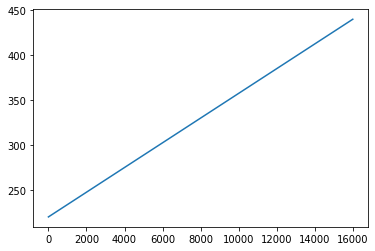

In [4]:
# Gestures: A transformation function specifying changes about an aspect of a sound.
# Gestures: Amplitude envelopes and frequency sweeps.
# Gestures are part of the generic synth model
#Gesture : start,stop, cutoff, numSamples

amp_env = SI.gesture(0.4,0.05, 1, 16000)
freq_sweep = SI.gesture(220, 440, 1, 16000)
plt.plot(freq_sweep)

### 2.1 Simple generator: 
Takes in amplitude curves and fundamental frequency to generate a signal with phase increments.
Variations with sine, sawtooth

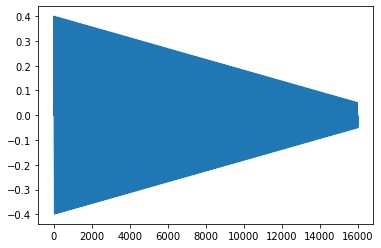

In [5]:
def simpleGenerator(n):
    amp_env = SI.gesture(0.4,0.05, 1, int(n * 16000))
    fund_freq = 220
    synth_out = []
    numSamples = int(n * 16000)        # 1 second * 16000 sample rate
    phase_increment = 2 * math.pi * fund_freq / 16000     # phase increment per sample
    phi = 0
    for index in range(numSamples):
        A = amp_env[index]
        inst_f = fund_freq
        val = A * math.sin(phi);    # output sample value for current sample
        phi += phase_increment
        phase_increment = 2 * math.pi * inst_f/16000 #constant phase increase
        synth_out.append(val)
    return synth_out

sig = simpleGenerator(1)
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

### 2.2 Sawtooth generator

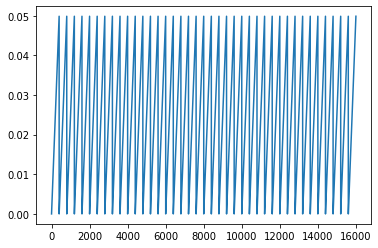

In [6]:
def sawtoothGeneration(n, samples):
    period = math.floor(samples/n)
    amp_env = SI.gesture(0.4,0.05, 0.6, period)
    synth_out = []
    numSamples = samples        # 1 second * 16000 sample rate
    for p in range(n):
        for index in range(period):
            A = amp_env[index]
            cutoff = 0.3 + 0.5*np.random.random()
            val = sawtooth(index, samples, cutoff);    # output sample value for current sample
            synth_out.append(val)
    return synth_out

sig = sawtoothGeneration(40, 16000)
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

### 2.3 Frequency sweep: 
Instaneous phase of the sinewave changes with the instanteous frequency
Appropriate changes in freuqnecy curves give a Drip sound

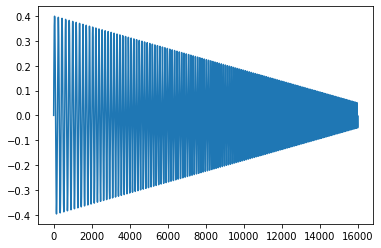

In [7]:
n_secs = 1

amp_env = SI.gesture(0.4,0.05, 1, int(n_secs * 16000))
freq_sweep = SI.gesture(80, 200, 1, int(n_secs * 16000))

def simpleSweep(n):
    synth_out = []
    numSamples = int(n * 16000)        # 1 second * 16000 sample rate
    phase_increment = 2 * math.pi * 220 / 16000     # phase increment per sample
    phi = 0
    for index in range(numSamples):
        A = amp_env[index]
        inst_f = freq_sweep[index]
        val = A * math.sin(phi);    # output sample value for current sample
        phi += phase_increment
        phase_increment = 2 * math.pi * inst_f/16000
        synth_out.append(val)
    return synth_out

sig = simpleSweep(n_secs)
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

### 2.4 Frequency sweep with sawtooth

[4.         4.66666667 5.33333333 6.         6.         5.66666667
 5.33333333 5.         4.66666667 4.33333333 4.        ]


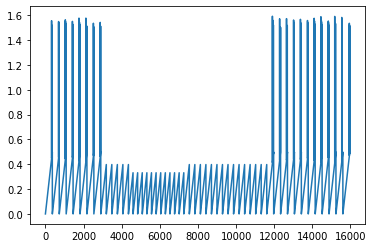

In [16]:
n_secs = 1
samples = int(n_secs*16000)
freq_sweep = SI.genericGesture(4, 6, 0.4, 8+int(4*np.random.random())) #odd number, 0.5 for equal cut off
# something about the duratin of the sound and the ratio (number of samples to peak) of the time to the peak value ~0.5
print(freq_sweep)
samplesPerFreq = int(samples/len(freq_sweep))
sig = np.concatenate([sawtoothGeneration(int(f),samplesPerFreq) for f in freq_sweep])
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

## 2. Explore individual sounds

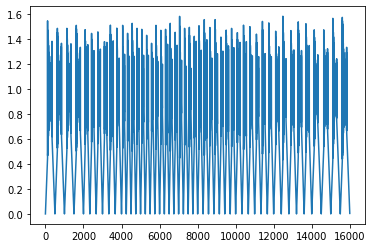

In [10]:
# Load synth model using the synth name or a variable 
synthname = "Engine"
myPop = soundModels[synthname].MySoundModel
foosynth=myPop(4, 4)

def genAndPlot(n):
    sig=foosynth.generate(n)  #1 second
    plt.plot(sig)
    display(Audio(sig, rate=16000, autoplay=True))

genAndPlot(4)

#### Get sound parameters

In [11]:
# A handy function to print the names and range of parameters using Synth
foosynth.printParams()

Name:  cf  Default value :  4  Max value  30  Min value  4
Name:  sweep  Default value :  4  Max value  10  Min value  0


In [12]:
# Get individual parameters
foosynth.getParam('cf') # Get a param value. 

4

#### Set sound parameters (natural ranges)

now the value of synth param f0 is 4


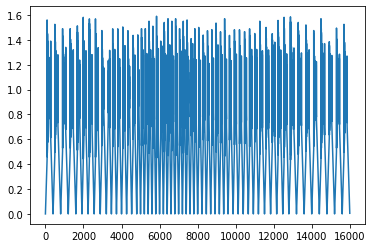

In [13]:
foosynth.setParam('sweep', 4) # Can set any synth parameter with setParam()
print("now the value of synth param f0 is {}".format(foosynth.getParam('sweep')))    # Get a param value. 
genAndPlot(1)

#### Set synth parameters (Normalized ranges)

now the value of synth param f0 is 4


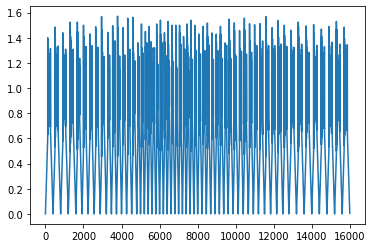

In [14]:
foosynth.setParamNorm('cf', 0)   #setParamNorm uses [0,1] range 
print("now the value of synth param f0 is {}".format(   foosynth.getParam('cf')    ))
genAndPlot(1)

#### Find min and max range of parameters exposed by the synth

In [15]:
fmin = foosynth.getParam('cf', "min")  # by default, getParam would get val, but here we ask for its min
print("min val of synth param f0 is {}".format(fmin))

fmax = foosynth.getParam('cf', "max")  # by default, getParam would get val, but here we ask for its min
print("min val of synth param f0 is {}".format(fmax))

min val of synth param f0 is 4
min val of synth param f0 is 30


### END OF SECTION 2: Here are some FUN_Experiments for new DSSYNTH Designers
- Set in Normalized range and find natural unit values
- Set in Normalized range and find natural unit values
- Set more than 1 sound parameter and find the change to the sounds
#### HINT: Always use genAndPlot() to hear how it sounds

## 3. Generate textures using synth interface and PatternSynth

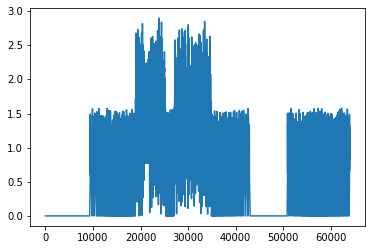

In [16]:
synthname = "Engine"
myPopPatternSynth = soundModels[synthname].PatternSynth

barsynth=myPopPatternSynth()

def genTexture(n):
    barsig=barsynth.generate(n)      #generates 4 seconds of drip sound
    plt.plot(barsig)
    display(Audio(barsig, rate=16000, autoplay=True))
    
genTexture(4)

### Change parameters (Natural ranges) to generate new textures

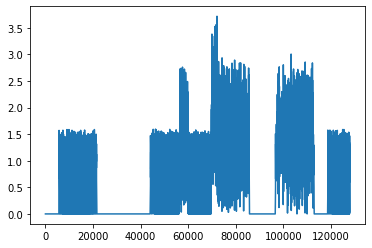

In [17]:
barsynth.setParam("rate",0) # will make 2^1 events per second
barsynth.setParam("irreg", 1)
barsynth.setParam("cf", 4)
genTexture(8)

### Change parameters (Normalized ranges) to generate new textures

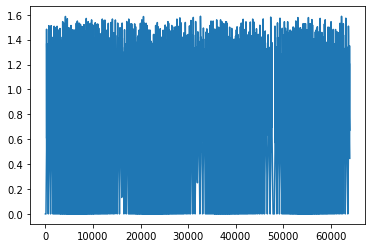

In [16]:
barsynth.setParamNorm("rate",0.5) # will make 2^1 events per second
barsynth.setParamNorm("irreg", 0.0)
barsynth.setParamNorm("cf", 0)
genTexture(4)

### END OF SECTION 3

## 4. ADVANCED Texture generation: 

### Visualize distribution of events
Notice that this code is model-independent (uses only SI utility function, no synth methods)

number of events is 8000


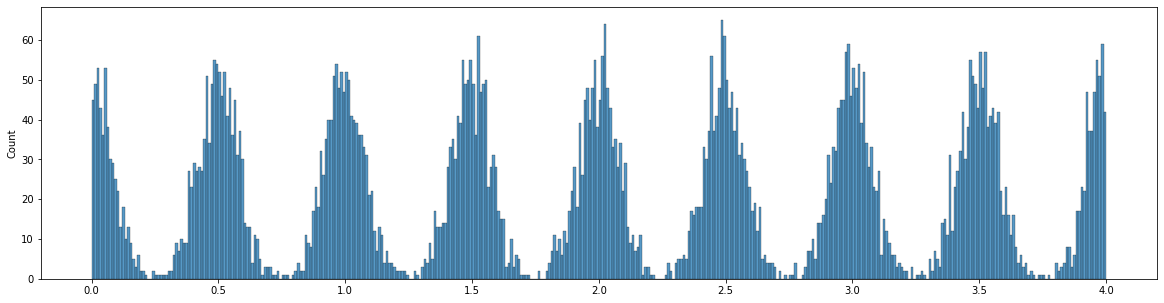

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

events=[]
for i in range(1000) :  #repeat to get enought samples to see the shape of the distribution
                                        #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds)
    events.extend(SI.noisySpacingTimeList(1, .5, 4))
print("number of events is {}".format(len(events)))
plt.figure(figsize=(20,5))
sns.histplot(events, bins=400)
plt.show()

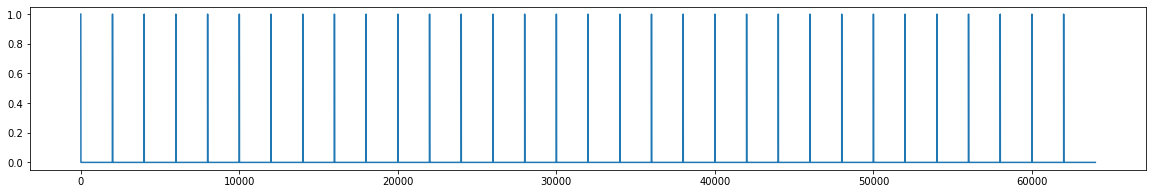

In [18]:
#params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds=p3)
elist = SI.noisySpacingTimeList(3, 0, 4)
esig = SI.timeList2Sig(elist,16000,4)

plt.figure(figsize=(20,3))
plt.plot(esig)

## END OF SECTION 4